# Mouse line analysis

In [2]:
%load_ext autoreload
%load_ext skip_kernel_extension
%autoreload 2

### Imports

In [3]:
# External packages
import logging
import os
import jupyter_slack
import datetime

# Internal modules
from logger import logger
from constants import *
from utils import *
from s2putils import *
from fileops import *
from postpro import *
from plotters import *
from substitutors import *
from filters import *

# Logger level
logger.setLevel(logging.INFO)

# Figures dictionary
figs = {}

### Input datasets and main processing parameters

In [5]:
analysis_type = DEFAULT_ANALYSIS  # Analysis type
mouseline = DEFAULT_LINE  # Mouse line
layer = None  # cortical layer
slack_notify = False
kalman_gain = KALMAN_GAIN  # Gain of Kalman filter
baseline_wlen = BASELINE_WLEN  # Length of rolling window for baseline computation
baseline_quantile = BASELINE_QUANTILE  # Evaluation quantile in folling window for baseline evaluation
baseline_smoothing = BASELINE_SMOOTHING   # Whether to smooth the baseline with an extra moving average
ykey_postpro = Label.DFF  # Variable of interest for post-processing

### Derived parameters

In [17]:
dataroot = get_data_root()
figsdir = get_output_equivalent(dataroot, 'raw', 'figs')
trialavg_root = get_output_equivalent(dataroot, 'raw', 'trial-averaged')
# Construct dataset group ID
dataset_group_id = mouseline
if layer is not None:
    dataset_group_id = f'{dataset_group_id}_{layer}'
# Construct post-processing ID
if baseline_wlen is None:
    baseline_smoothing = False
    baseline_id = ''
else:
    baseline_id = f'w{baseline_wlen:.1f}s'
baseline_id = f'{baseline_id}_q{baseline_quantile:.2f}'
if baseline_smoothing:
    baseline_id = f'{baseline_id}_smooth'
postpro_id = f'{baseline_id}_{ykey_postpro}'.replace('/', '')
# Get figures PDF suffix
figs_suffix = f'{dataset_group_id}_k{kalman_gain}_{postpro_id}'
# Get trial-averaged input data directory
submap = [(1, 0), (FrameIndex.STIM - 1, FrameIndex.STIM)]
ss = StackSubstitutor(submap, repeat_every=NFRAMES_PER_TRIAL)
kd = KalmanDenoiser(kalman_gain) if kalman_gain > 0 else NoFilter
s2p_ops = {
    'tau': TAU_GCAMP6S_DECAY,  # timescale of the sensor
    'fs': BRUKER_SR,  # sampling rate (per plane)
    'do_registration': 1,  # whether or not to perform image registration,
    'reg_tif': True,  # whether or not to write the registered binary to tiff files
    'nonrigid': True,  # whether or not to perform non-rigid registration, which splits the field of view into blocks and computes registration offsets in each block separately.
    'denoise': False,  # perform PCA denoising of the registered stack prior to ROI detection
}
defops = default_ops()
s2p_ops = get_normalized_options(s2p_ops, defops)            
diff_from_default_ops = compare_options(s2p_ops, defops)['input'].to_dict()
s2p_code = 'suite2p'
if diff_from_default_ops is not None:
    s2p_code = f'{s2p_code}_{get_options_code(diff_from_default_ops)}'
trialavg_dir = os.path.join(
    trialavg_root, baseline_id, s2p_code, kd.code, ss.code, analysis_type, mouseline)
# Get time stamp from notebook start
tstamp_start = datetime.datetime.now()
fmts = ['%Y-%m-%d', '%H:%M:%S']
# Log start process
s = f'{dataset_group_id} batch notebook started on {tstamp_start.strftime(fmts[0])} at {tstamp_start.strftime(fmts[1])}'
if slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

 06/10/2022 19:11:25: line3 batch notebook started on 2022-10-06 at 19:11:25


### Input summary table figure

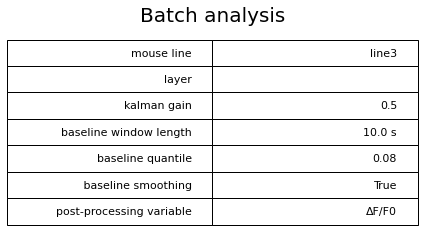

In [18]:
figs['dataset_info'] = plot_table({
    'mouse line': mouseline,
    'layer': layer,
    'kalman gain': kalman_gain,
    'baseline window length': f'{baseline_wlen:.1f} s',
    'baseline quantile': baseline_quantile,
    ' baseline smoothing': baseline_smoothing,
    'post-processing variable': ykey_postpro
    }, title='Batch analysis')

## Input data

### Load data

In [20]:
# Determine exclude patterns
exclude_patterns = None

# Determine what to do in case of duplicate runs
on_duplicate_runs = 'drop'

# Load datasets
logger.info(f'loading data from {trialavg_dir}:')
data = load_trialavg_datasets(
    trialavg_dir, layer=layer, exclude_patterns=exclude_patterns,
    on_duplicate_runs=on_duplicate_runs)

 06/10/2022 19:12:34: loading data from /Users/tlemaire/Documents/data/usnm/trial-averaged/w10.0s_q0.08_smooth/suite2p_fs_3.56_reg_tif_tau_1.25/kd_G0.5_V0.05_npad10/submap0<-1_9->10_every100/main/line3:
 06/10/2022 19:12:34: loading trial-averaged data from 20190704_mouse2_region1.h5
 06/10/2022 19:12:35: loading trial-averaged data from 20190704_mouse3_region1.h5
 06/10/2022 19:12:35: loading trial-averaged data from 20190707_mouse1_region1.h5
 06/10/2022 19:12:35: loading trial-averaged data from 20190807_mouse5_region1.h5
 06/10/2022 19:12:35: loading trial-averaged data from 20190807_mouse6_region1.h5
 06/10/2022 19:12:35: loading trial-averaged data from 20190829_mouse10_region1.h5
 06/10/2022 19:12:36: loading trial-averaged data from 20191107_mouse1_region1.h5
 06/10/2022 19:12:36: loading trial-averaged data from 20191107_mouse1_region2.h5
 06/10/2022 19:12:36: loading trial-averaged data from 20191108_mouse6_region1.h5
 06/10/2022 19:12:36: loading trial-averaged data from 201

### Breakdown per mouse region, cell maps & filter out datasets

 06/10/2022 19:14:02: extracting timeseries and stats from data...
 06/10/2022 19:14:03: plotting cells map color-coded by response type...
 06/10/2022 19:14:03: extracting responses types per ROI...
 06/10/2022 19:14:07: plotting cells map color-coded by response type...
 06/10/2022 19:14:07: extracting responses types per ROI...
 06/10/2022 19:14:10: plotting cells map color-coded by response type...
 06/10/2022 19:14:10: extracting responses types per ROI...
 06/10/2022 19:14:11: plotting cells map color-coded by response type...
 06/10/2022 19:14:11: extracting responses types per ROI...
 06/10/2022 19:14:13: plotting cells map color-coded by response type...
 06/10/2022 19:14:13: extracting responses types per ROI...
 06/10/2022 19:14:17: plotting cells map color-coded by response type...
 06/10/2022 19:14:17: extracting responses types per ROI...
 06/10/2022 19:14:20: plotting cells map color-coded by response type...
 06/10/2022 19:14:20: extracting responses types per ROI...
 0

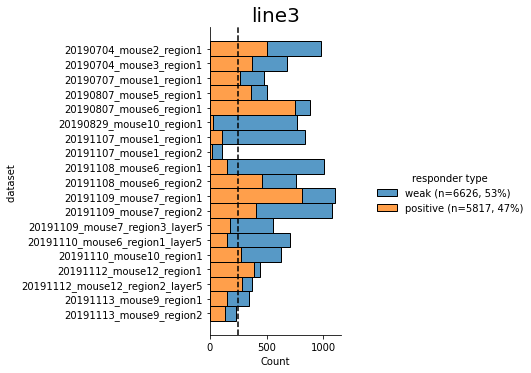

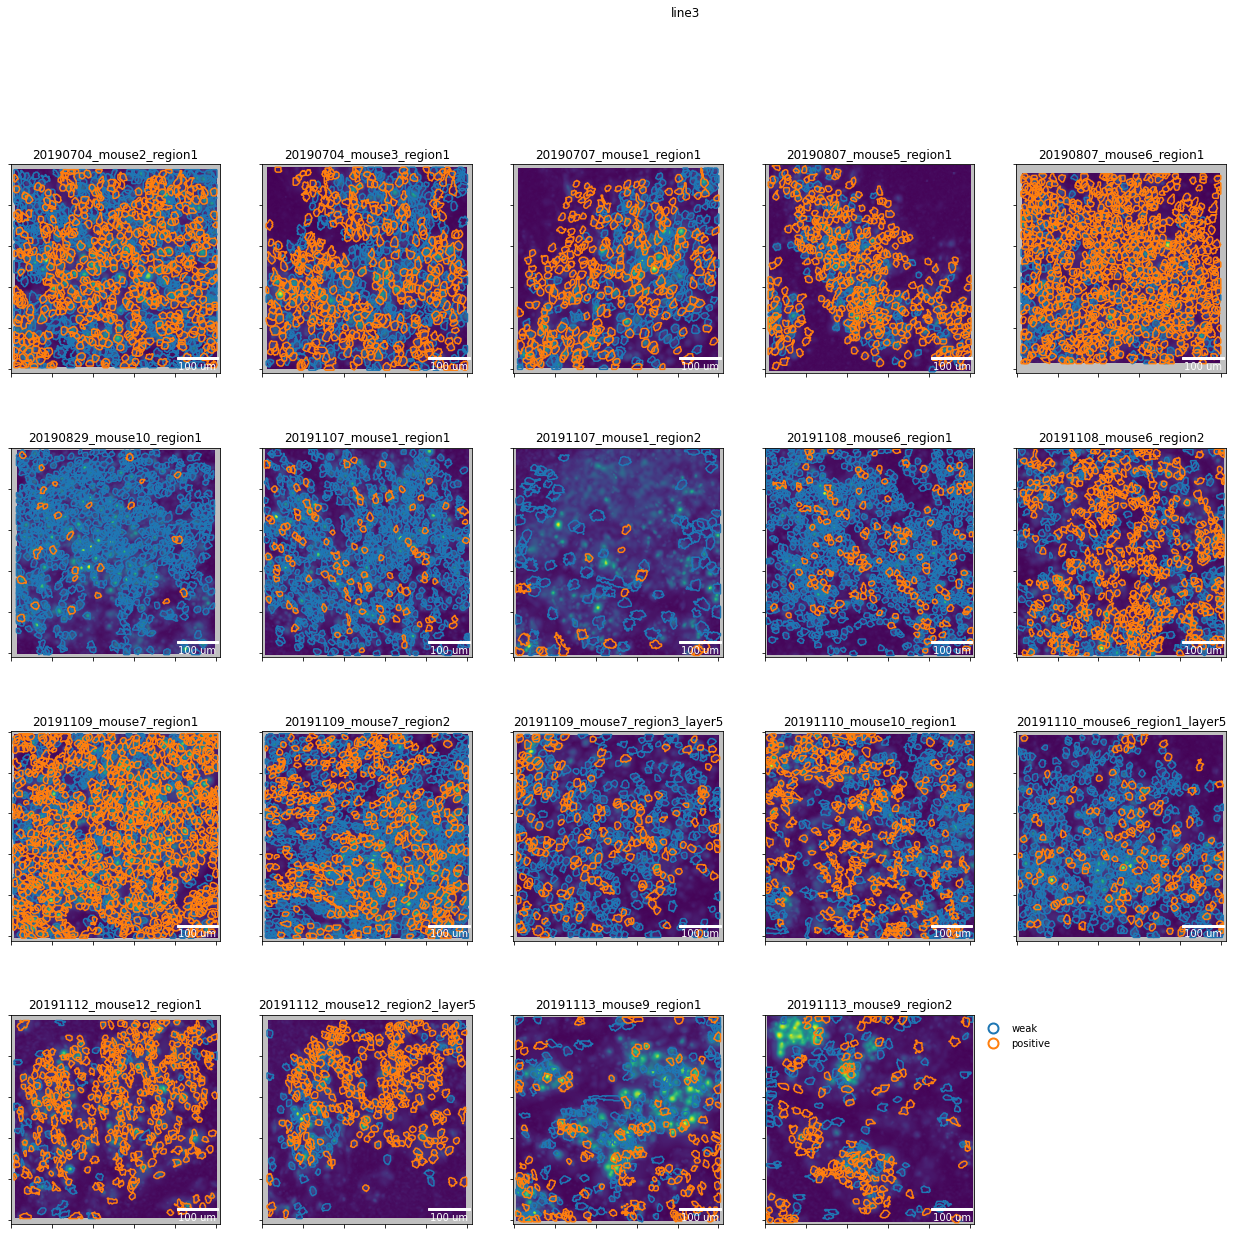

In [21]:
logger.info('extracting timeseries and stats from data...')
timeseries, stats, ROI_masks, map_ops = data['timeseries'], data['stats'], data['ROI_masks'], data['map_ops']

# Compute cell count threshold
um_per_px = 1.96  # from Bruker microscope
npx_per_line = 256  # from Bruker miscroscope
area = (um_per_px * npx_per_line)**2 / 1e6  # mm2
min_cell_count = int(np.round(MIN_CELL_DENSITY[mouseline] * area))

# Plot breakdown
figs['rtype dist per mousereg'] = plot_cellcounts_by_type(
    stats, hue=Label.ROI_RESP_TYPE, countref=min_cell_count,
    title=mouseline)

figs['cellmaps'] = plot_cell_maps(
        ROI_masks, stats, map_ops, title=mouseline, refkey='Vcorr', mode='contour')

# Idendify datasets with a low overall cell count
logger.info(f'setting minimum cell count of {min_cell_count} as inclusion criterion')
cells = stats.groupby([Label.DATASET, Label.ROI]).first()
cellcounts = cells.groupby(Label.DATASET).count().iloc[:, 0].rename('cell count')
weaks = cells.loc[cells[Label.ROI_RESP_TYPE] == 'weak']
weakcounts = weaks.groupby(Label.DATASET).count().iloc[:, 0].rename('weak count')
pctresp = (1 - (weakcounts / cellcounts)) * 100
count_exclude = cellcounts.loc[cellcounts < min_cell_count].index.values.tolist()
count_exclude = []
# Manual exclusions
manual_exclude = {
    'line3': [], #'20191109_mouse7_region2'
    'sst': ['20190808_mouse6_region1'],
    'pv': []
}[mouseline]

# Exclude them
timeseries, stats = exclude_datasets(timeseries, stats, count_exclude + manual_exclude)

## Parameter dependency curves

### Plotting function

In [22]:
logger.info('defining plotting function...')

def plot_dep_curves(stats, ykey, title=None, detailed=True, weighted=False, **kwargs):
    logger.setLevel(logging.WARNING)
    # If detailed mode, one graph per response type
    suffix = '' if title is None else title
    if detailed:
        for pkey in [Label.P, Label.DC]:
            figs[f'{pkey}-dep {ykey}{suffix}'] = plot_parameter_dependency_across_datasets(
                stats, pkey, ykey, weighted=weighted, **kwargs)
            if title is not None:
                figs[f'{pkey}-dep {ykey}'].suptitle(title)
    # Otherwise, single graph with all response types
    else:
        # If weighted, aggregate for each dataset
        if weighted:
            df = stats.copy()
        else:
            df = resolve_columns(
                stats.groupby([Label.DATASET, Label.ROI_RESP_TYPE, Label.RUN]).mean(), 
                [Label.P, Label.DC])
        # Get keys for pre, post and change
        ykey_diff = get_change_key(ykey)
        figs[f'alldeps {ykey}{suffix}'] = plot_stimparams_dependency_per_response_type(
            df, ykey_diff, hue=Label.ROI_RESP_TYPE, yref=0, title=title, **kwargs)
    logger.setLevel(logging.INFO)

 06/10/2022 19:16:23: defining plotting function...


### With default parameters

 06/10/2022 19:16:27: plotting parameter dependencies
 06/10/2022 19:16:28: plotting detailed parameter dependencies


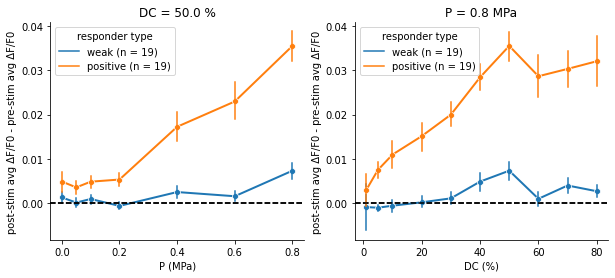

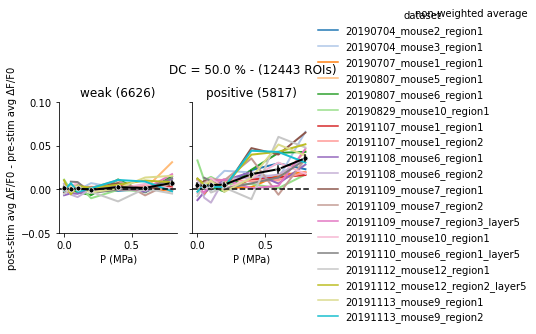

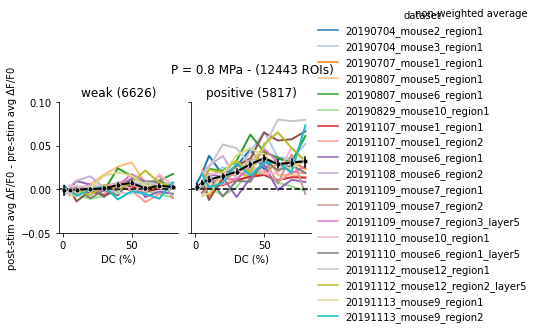

In [23]:
for detailed in [False, True]:
    logger.info(f'plotting {"detailed " if detailed else ""}parameter dependencies')
    plot_dep_curves(
        stats, ykey_postpro, detailed=detailed, err_style='bars')

## Response traces

### Get plot-ready traces dataset

In [24]:
plt_data = get_plot_data(timeseries, stats)

 06/10/2022 19:17:00: merging timeseries and stats information...
 06/10/2022 19:18:26: adding time info to table...


### Pressure-dependent response traces

 06/10/2022 19:20:48: plotting P (MPa) dependency curves for positive responders...
 06/10/2022 19:20:51: sub-indexing data...
 06/10/2022 19:20:51: filtering data...
 06/10/2022 19:20:53: cross-checking filters...
 06/10/2022 19:20:56: grouping by dataset, grouping by P (MPa), averaging and plotting mean ΔF/F0 vs. time (s) ...
 06/10/2022 19:21:42: plotting P (MPa) dependency curves for weak responders...
 06/10/2022 19:21:47: sub-indexing data...
 06/10/2022 19:21:47: filtering data...
 06/10/2022 19:21:49: cross-checking filters...
 06/10/2022 19:21:54: grouping by dataset, grouping by P (MPa), averaging and plotting mean ΔF/F0 vs. time (s) ...


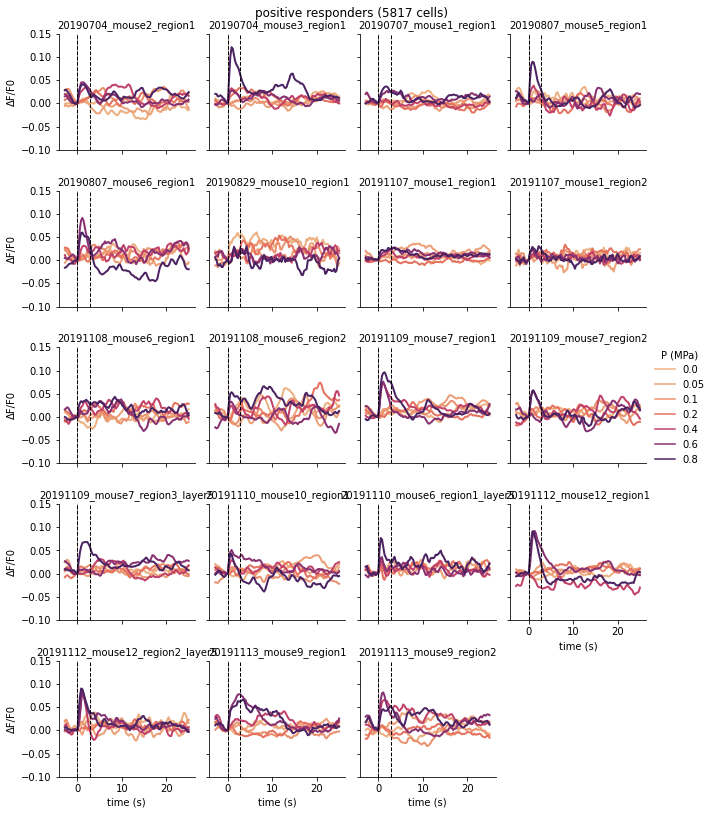

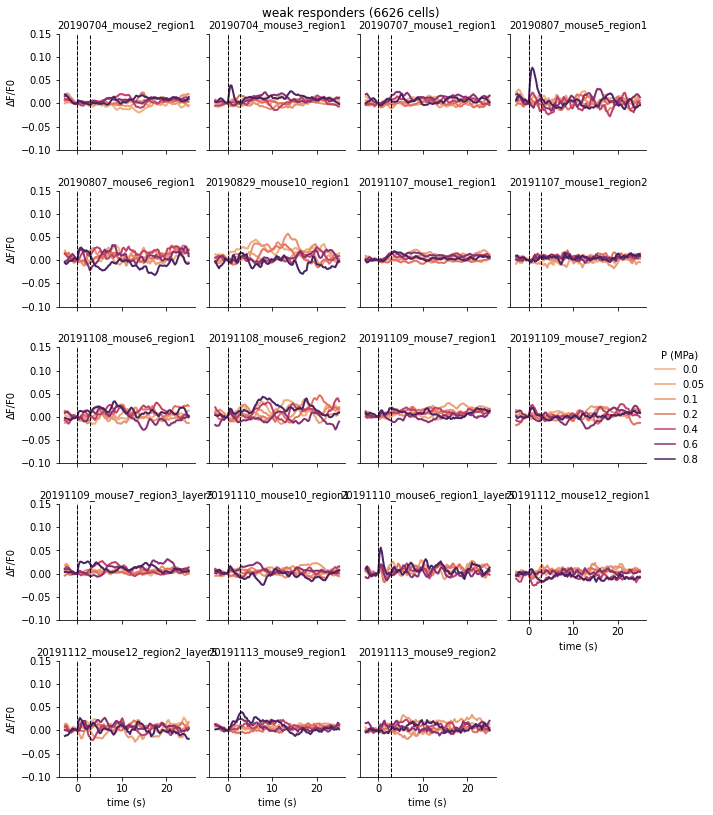

In [25]:
figs.update(
    plot_responses_across_datasets(plt_data, ykey=ykey_postpro, pkey=Label.P))

### DC-dependent response traces

 06/10/2022 19:23:02: plotting DC (%) dependency curves for positive responders...
 06/10/2022 19:23:06: sub-indexing data...
 06/10/2022 19:23:07: filtering data...
 06/10/2022 19:23:10: cross-checking filters...
 06/10/2022 19:23:14: grouping by dataset, grouping by DC (%), averaging and plotting mean ΔF/F0 vs. time (s) ...
 06/10/2022 19:24:07: plotting DC (%) dependency curves for weak responders...
 06/10/2022 19:24:12: sub-indexing data...
 06/10/2022 19:24:12: filtering data...
 06/10/2022 19:24:16: cross-checking filters...
 06/10/2022 19:24:21: grouping by dataset, grouping by DC (%), averaging and plotting mean ΔF/F0 vs. time (s) ...


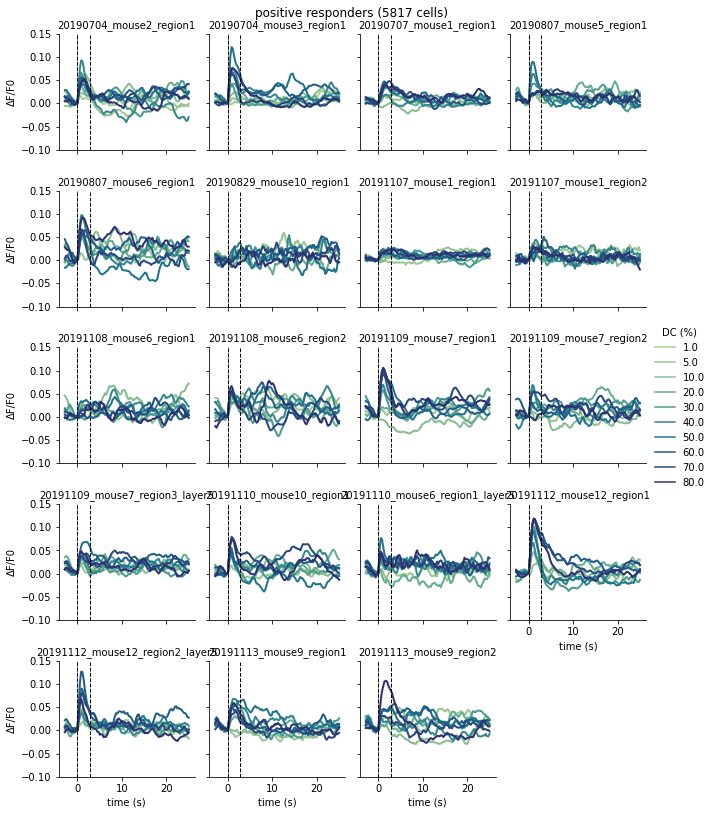

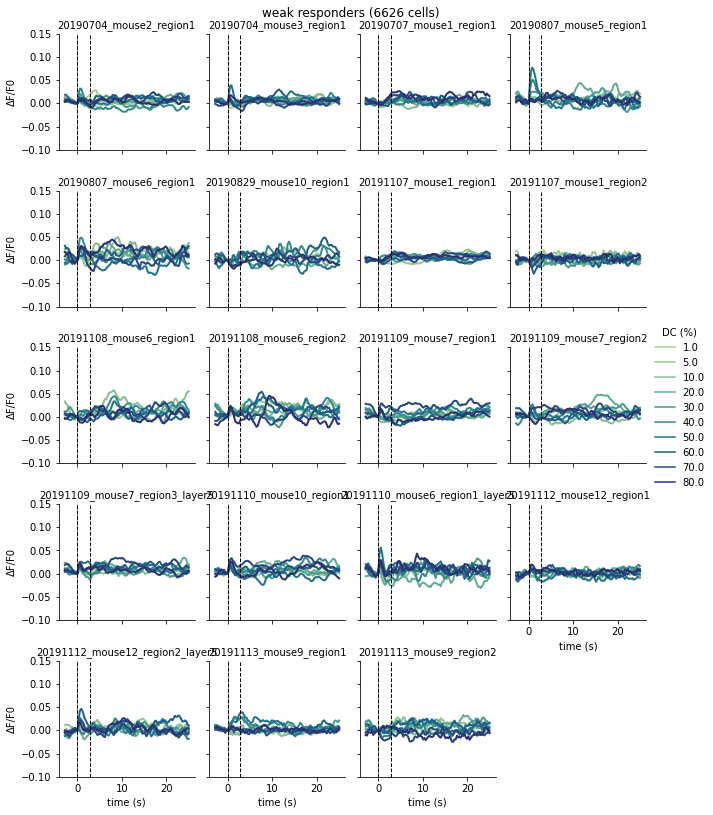

In [26]:
figs.update(
    plot_responses_across_datasets(plt_data, ykey=ykey_postpro, pkey=Label.DC))

### Average response traces across datasets (weighted)

 06/10/2022 19:25:27: sub-indexing data...
 06/10/2022 19:25:27: filtering data...
 06/10/2022 19:25:39: cross-checking filters...
 06/10/2022 19:25:48: grouping by responder type, grouping by P (MPa), averaging and plotting mean ΔF/F0 vs. time (s) ...
 06/10/2022 19:26:57: sub-indexing data...
 06/10/2022 19:26:57: filtering data...
 06/10/2022 19:27:12: cross-checking filters...
 06/10/2022 19:27:29: grouping by responder type, grouping by DC (%), averaging and plotting mean ΔF/F0 vs. time (s) ...


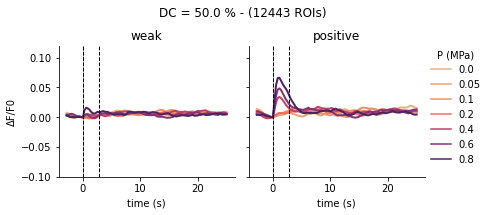

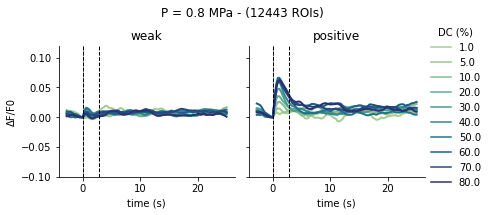

In [27]:
# Plot response curves for both input stimulation parameters  
for pkey in [Label.P, Label.DC]:
    figs[f'{ykey_postpro} vs. {pkey} by type - weighted'] = plot_responses_across_datasets(
        plt_data, ykey=ykey_postpro, pkey=pkey, avg=True)

### Average response traces across datasets (non-weighted)

 06/10/2022 19:28:55: checking for run order consistency across datasets...
 06/10/2022 19:29:17: computing average traces per dataset and condition...
 06/10/2022 19:29:29: sub-indexing data...
 06/10/2022 19:29:29: filtering data...
 06/10/2022 19:29:29: cross-checking filters...
 06/10/2022 19:29:29: grouping by responder type, grouping by P (MPa), averaging and plotting mean ΔF/F0 vs. time (s) ...
 06/10/2022 19:29:30: sub-indexing data...
 06/10/2022 19:29:30: filtering data...
 06/10/2022 19:29:30: cross-checking filters...
 06/10/2022 19:29:30: grouping by responder type, grouping by DC (%), averaging and plotting mean ΔF/F0 vs. time (s) ...


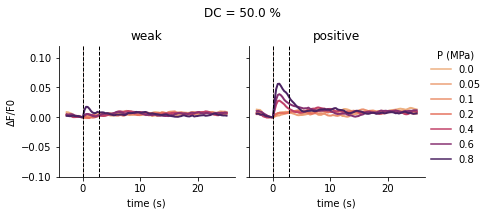

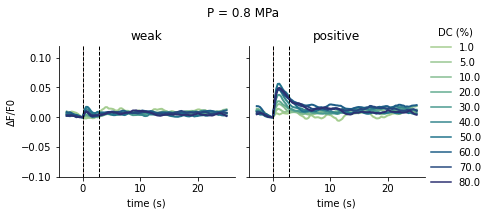

In [28]:
# Check run order consistency across datasets
logger.info('checking for run order consistency across datasets...')
params_per_run = plt_data.groupby([Label.DATASET, Label.RUN]).first()[[Label.P, Label.DC]]
for k in params_per_run:
    sum_of_stds = params_per_run[k].unstack().std().sum()
    if sum_of_stds > 1e-12:
        logger.error('variation in run orders across dataset')

# Group data by mouse-region, response type, run and frame -> average
logger.info('computing average traces per dataset and condition...')
avg_plt_data = plt_data.groupby(
    [Label.DATASET, Label.ROI_RESP_TYPE, Label.RUN, Label.FRAME]).mean()
avg_plt_data = resolve_columns(avg_plt_data, [Label.P, Label.DC, Label.DUR, Label.TIME])

# Plot response curves for both input stimulation parameters
for pkey in [Label.P, Label.DC]:
    figs[f'{ykey_postpro} vs. {pkey} by type - nonweighted'] = plot_responses_across_datasets(
        avg_plt_data, ykey=ykey_postpro, pkey=pkey, avg=True)

### Save figures

In [29]:
figs = {k: v for k, v in figs.items() if v is not None}
save_figs_book(figsdir, figs, suffix=figs_suffix)

 06/10/2022 19:29:30: saving figures in /Users/tlemaire/Documents/data/usnm/figs/2022.10.06/figs_line3_k0.5_w10.0s_q0.08_smooth_ΔFF0.pdf:


100%|██████████| 14/14 [00:11<00:00,  1.20it/s]


### Notify upon completion

In [30]:
# Get time stamp from notebook completion
tstamp_end = datetime.datetime.now()

# Log completion process
s = f'{mouseline} batch notebook completed in {tstamp_end - tstamp_start} s'
if slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

 06/10/2022 19:29:43: line3 batch notebook completed in 0:18:17.936116 s
